# The NBA Golden Game

Growing up, every child learns about their "golden birthday," the one year that their age matches up to their birthdate exactly. As a huge NBA fan and and huger stats nerd, I always get excited when a player scores the exact number of points as their jersey number.

I've started calling this the Golden Game, and I'll be taking a look at its occurrences over the past 30 years of basketball history. How common is a Golden Game? Which players have the best Golden Game stats? Let's find out.


## Collecting the data
To answer these questions, I'll need a dataset with not only per-game player stats, but also each player's jersey number during that game (since players do change numbers throughout their careers).

I started with visiting the NBA's official stats site to download the per-game stats, starting from my birth year--30 years worth of individual player stats for each game. (Split into two files be able to store on GitHub.)

The data needed a bit of cleanup, mainly that team abbreviations have changed over time, so I checked for inconsistencies before replacing the outdated abbreviations with current ones.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

df_stats = pd.read_csv('stats1990-2004.csv', low_memory=False)
df_stats2 = pd.read_csv('stats2005-2020.csv', low_memory=False)
df_stats = df_stats.append(df_stats2, ignore_index=True)
df_stats.rename(columns=lambda x: x.strip(), inplace=True)
df_stats['PLAYER_NO'] = ''

df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].str.lstrip()
df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].replace('GOS', 'GSW')
df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].replace('BKN', 'BRK')
df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].replace('PHL', 'PHI')
df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].replace('PHX', 'PHO')
df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].replace('SAN', 'SAS')
df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_ABBREVIATION'].replace('UTH', 'UTA')

df_stats['PLAYER_NAME'] = df_stats['PLAYER_NAME'].str.lstrip()
df_stats['SEASON_ID'] = df_stats['SEASON_ID'].apply(str)
df_stats['SEASON_ID'] = df_stats['SEASON_ID'].apply(lambda x: re.sub('^\d', '', x))
df_stats['PTS'] = df_stats['PTS'].apply(str)
df_stats.head()

,Unnamed: 0,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PLUS_MINUS,PLAYER_NO
0,0,1990,77142,Magic Johnson,1610612747,LAL,Los Angeles Lakers,49000068,1991-06-12,LAL vs. CHI,...,1.0,4,7,11,20,1,0,6,None,
1,1,1990,77377,Cliff Levingston,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,None,1,1,2,0,0,0,0,None,
2,2,1990,77820,John Paxson,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,1.0,0,3,3,4,1,0,1,None,
3,3,1990,77034,Craig Hodges,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,None,0,0,0,0,0,0,0,None,
4,4,1990,769,B.J. Armstrong,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,None,0,0,0,0,1,0,1,None,


The NBA doesn't have an easy source for grabbing the player numbers with the above stats, so I had to resort to crawling another popular NBA stats site, basketball-reference.com. In playerno_scrape.py, I crawled through each season to grab every team's roster and player numbers. I've imported that data here from player_nos.csv.

In [3]:
df_player_nos = pd.read_csv('player_nos.csv')
df_player_nos['season'] = df_player_nos['season'].apply(str)
df_player_nos['name'] = df_player_nos['name'].apply(lambda x: re.sub('\(TW\)', '', x))
df_player_nos['name'] = df_player_nos['name'].str.rstrip()

df_player_nos['number'] = df_player_nos['number'].str.replace(r'\-\d+','')
df_player_nos.head()

,Unnamed: 0,season,team,number,name
0,0,2019,MIL,9,Wesley Matthews
1,1,2019,MIL,11,Brook Lopez
2,2,2019,MIL,24,Pat Connaughton
3,3,2019,MIL,42,Robin Lopez
4,4,2019,MIL,0,Donte DiVincenzo


Now for the fun part, merging the two datasets. Since I'm trying to get jersey number data for every player in every game, and players can move teams throughout the season, I can't just match the names in both datasets and merge on that. Instead, I opted to create a unique key for each player in every game, and then mash together an identical key from the player_nos.csv set.

The pattern will be: Team abbreviation + player name + season (year)

In [4]:
df_stats['key'] = ''
df_stats['key'] = df_stats.apply(lambda x: df_stats['TEAM_ABBREVIATION'] + df_stats['PLAYER_NAME'] + df_stats['SEASON_ID'])
df_player_nos['key'] = ''
df_player_nos['key'] = df_player_nos.apply(lambda x: df_player_nos['team'] + df_player_nos['name'] + df_player_nos['season'])

df_stats_nos = pd.merge(df_stats, df_player_nos, how='left', on='key')
df_stats_nos.head()

,Unnamed: 0_x,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,BLK,TOV,PLUS_MINUS,PLAYER_NO,key,Unnamed: 0_y,season,team,number,name
0,0,1990,77142,Magic Johnson,1610612747,LAL,Los Angeles Lakers,49000068,1991-06-12,LAL vs. CHI,...,0,6,None,,LALMagic Johnson1990,14994.0,1990,LAL,32,Magic Johnson
1,1,1990,77377,Cliff Levingston,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,0,0,None,,CHICliff Levingston1990,14769.0,1990,CHI,53,Cliff Levingston
2,2,1990,77820,John Paxson,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,0,1,None,,CHIJohn Paxson1990,14770.0,1990,CHI,5,John Paxson
3,3,1990,77034,Craig Hodges,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,0,0,None,,CHICraig Hodges1990,14765.0,1990,CHI,14,Craig Hodges
4,4,1990,769,B.J. Armstrong,1610612741,CHI,Chicago Bulls,49000068,1991-06-12,CHI @ LAL,...,0,1,None,,CHIB.J. Armstrong1990,14762.0,1990,CHI,10,B.J. Armstrong


That looks like it worked! We now have the jersey number for every player, attached to the giant data set of individual game statistics (albeit with some duplicate columns).

Luckily, we can now move on from the giant dataset, and get to what I'm really looking for: the Golden Games.

## Finding the Golden Games
Since I made up the Golden Game concept in the first place, I also get to define for myself what a Golden Game is.
At its core, a Golden Game should have:
1. The player's points scored are equal to their jersey number
2. The player has actually entered the game (zero points on the bench doesn't count for any number 0s)

And that's it for now!
Going with that definition, we can get the following subset of data.

In [5]:
df_golden = df_stats_nos[(df_stats_nos['PTS'] == df_stats_nos['number']) & (df_stats_nos['MIN'] > 0)]
df_golden = df_golden[['PLAYER_NAME','PTS','number']]
df_golden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18774 entries, 24 to 798554
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLAYER_NAME  18774 non-null  object
 1   PTS          18774 non-null  object
 2   number       18774 non-null  object
dtypes: object(3)
memory usage: 586.7+ KB


Looks like we've got 18,774 players with Golden Games over the past 30 years. With the whole dataset consisting of 798,640 player stats, that's only about **2.4%** of games!

Now let's take a look at the top 30 Golden Game scorers.

In [6]:
df_golden = df_golden.groupby(['PLAYER_NAME','PTS']).agg(['count']).reset_index()
df_golden.columns = ['PLAYER_NAME','PTS','COUNT']
df_golden = df_golden.sort_values('COUNT', ascending=False)
df_golden.head(30)

,PLAYER_NAME,PTS,COUNT
2075,Walter McCarty,0,165
1847,Stacey Augmon,2,146
1520,Nick Collison,4,139
1960,Tony Battie,4,130
1367,Mark Bryant,2,114
1044,John Stockton,12,93
1122,Keith Askins,2,90
1573,Pau Gasol,16,87
539,Derek Fisher,2,84
153,Avery Johnson,6,83


I guess we shouldn't be surprised that the \#1 occuring Golden Game is for a player that wears 0. It's almost impressive in its own right--actually playing in 165 games but not scoring any points (presumably he contributed in other ways!).

It also isn't too surprising that we have a lot of lower numbers in the top 30.
There are definitely some impressive scorers up there though, notably Tim Duncan and Gary Payton in the top 15.

Let's take a look at this top 30 in graph form.

[Text(0.5, 1.0, 'NBA Golden Games, 1990-2019 Seasons'),
 Text(0.5, 0, 'Number of Games'),
 Text(0, 0.5, 'Player, Jersey No./Pts.')]

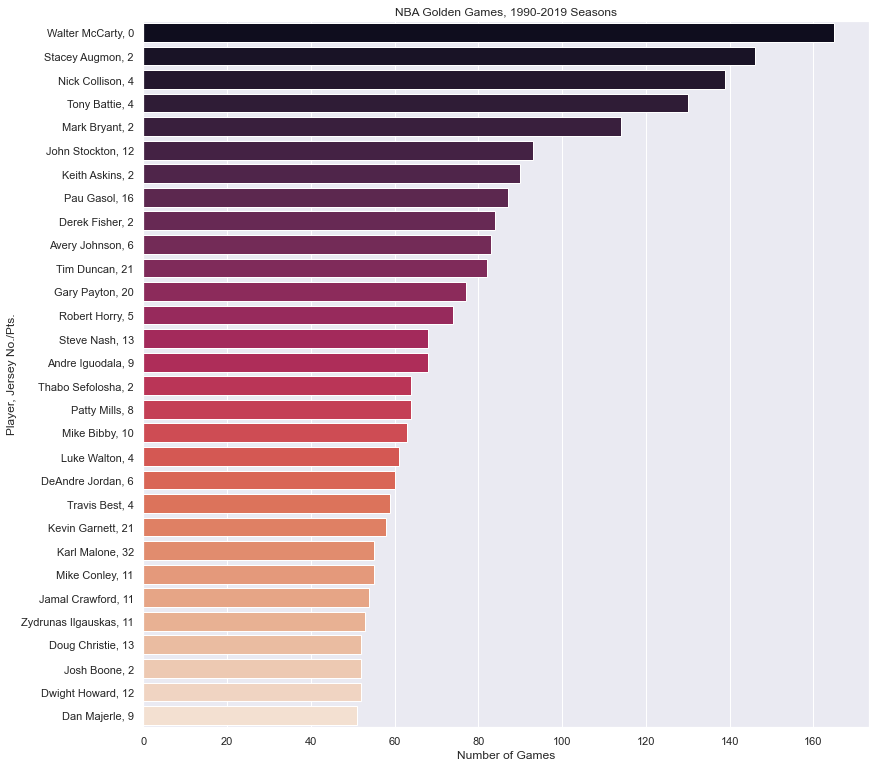

In [7]:
df_golden['NAME_NO'] = df_golden['PLAYER_NAME'] + ', ' + df_golden['PTS']
df_golden_30 = df_golden[0:30]

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
sns.barplot(x='COUNT', y='NAME_NO', data=df_golden_30, ci=None, palette='rocket')
ax.set(title='NBA Golden Games, 1990-2019 Seasons', xlabel='Number of Games', ylabel='Player, Jersey No./Pts.')

Definitely puts it into perspective how impressive the top 5's numbers are.
Walter McCarty more than doubles most of the list!


### Redefining the Golden Game
Let's be honest though--Scoring only 4 points to match your jersey is cool, but it gets _really_ impressive when you're scoring a lot of points. (Says the guy sitting behind his keyboard, I know, I know.)

Let's add another requirement to the Golden Game, and call it the Golden Game Plus:
1. The player's points scored are equal to their jersey number
2. The player has actually entered the game (zero points on the bench doesn't count for any number 0s)
3. **The player's jersey number (and thus their points scored) must be more than 20**

Now who is in the top 30?

[Text(0.5, 1.0, 'NBA Golden Games, 1990-2019 Seasons'),
 Text(0.5, 0, 'Number of Games'),
 Text(0, 0.5, 'Player, Jersey No./Pts.')]

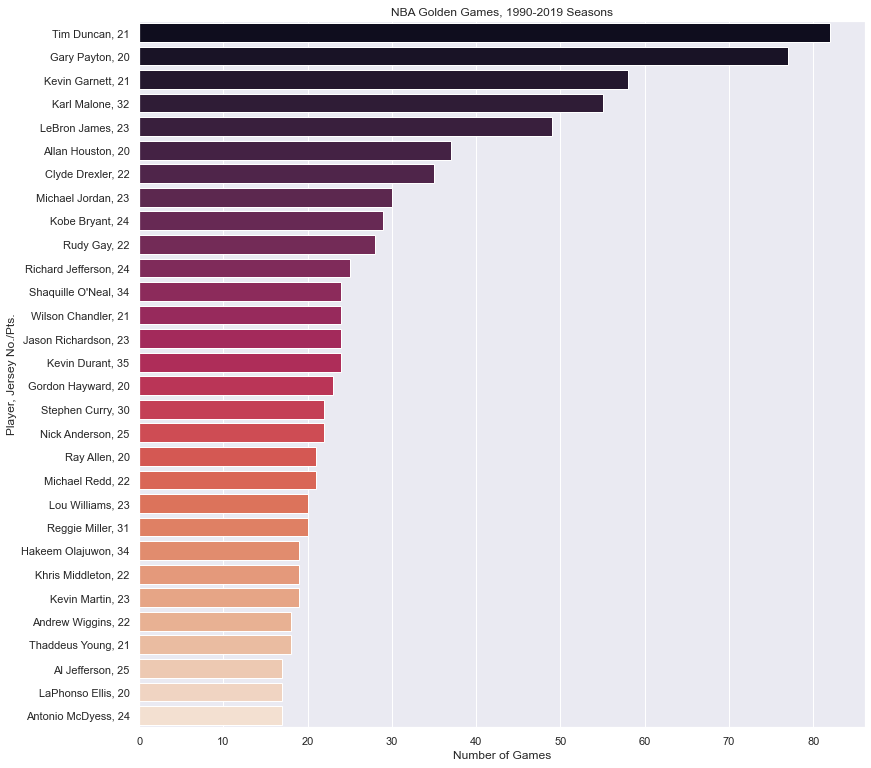

In [8]:
df_golden_plus = df_golden[df_golden['PTS'].apply(int) >= 20]
df_golden_plus_30 = df_golden_plus[0:30]
df_golden_plus_30 = df_golden_plus_30[['NAME_NO', 'COUNT']]

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
sns.barplot(x='COUNT', y='NAME_NO', data=df_golden_plus_30, ci=None, palette='rocket')
ax.set(title='NBA Golden Games, 1990-2019 Seasons', xlabel='Number of Games', ylabel='Player, Jersey No./Pts.')

Now we see a lot more "traditionally" famous scorers, like LeBron James, Kobe Bryant, and Kevin Durant. On top of that, the disparity between the top 5 and the rest of the players is even more impressive than before.

When people talk about the greatest NBA player of all time though, let's be honest. It's not Tim Duncan vs. Michael Jordan, it's LeBron James.

Let's update the definition one more time, to stop penalizing players who go above and beyond to score more points than their jersey number.

1. The player's points scored are **greater than or equal to** their jersey number
2. The player has participated in the game (zero points on the bench doesn't count for any number 0s)
3. The player's jersey number (and thus their points scored) must be more than 20

[Text(0.5, 1.0, 'NBA Golden Games, 1990-2019 Seasons'),
 Text(0.5, 0, 'Number of Games'),
 Text(0, 0.5, 'Player, Jersey No./Minimum Pts.')]

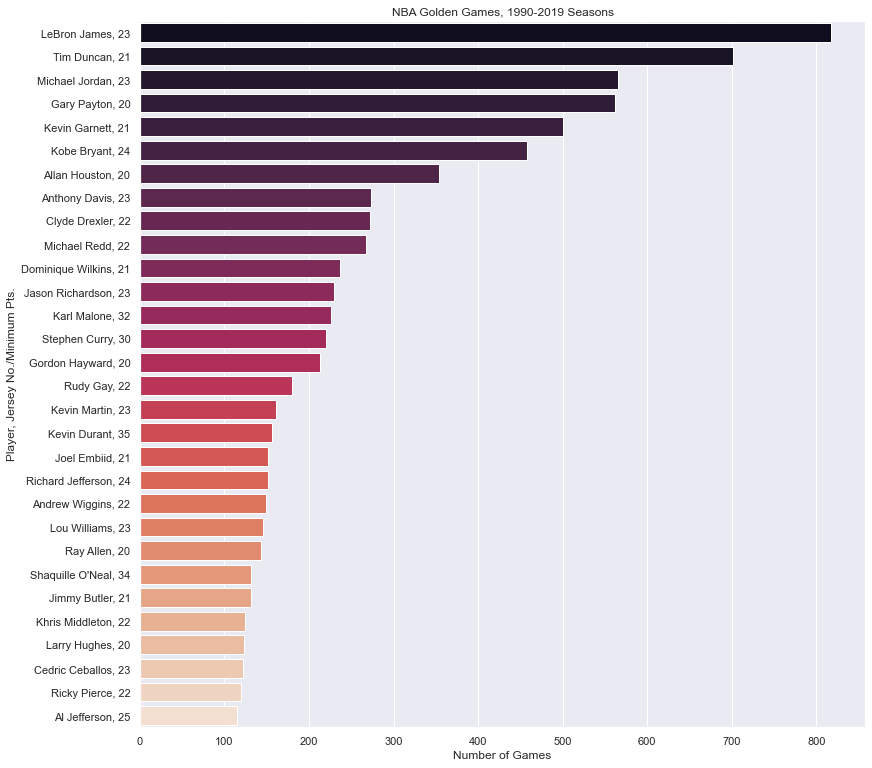

In [9]:
df_golden_over = df_stats_nos[df_stats_nos['number'].notna()]
df_golden_over = df_golden_over[(df_golden_over['number'].apply(int) >= 20) & (df_golden_over['PTS'].apply(int) >= df_golden_over['number'].apply(int)) & (df_golden_over['MIN'] > 0)]
df_golden_over = df_golden_over[['PLAYER_NAME','PTS','number']]
df_golden_over = df_golden_over.groupby(['PLAYER_NAME','number']).agg(['count']).reset_index()
df_golden_over.columns = ['PLAYER_NAME','PTS','COUNT']
df_golden_over = df_golden_over.sort_values('COUNT', ascending=False)
df_golden_over['NAME_NO'] = df_golden_over['PLAYER_NAME'] + ', ' + df_golden_over['PTS']

df_golden_over_30 = df_golden_over[0:30]
df_golden_over_30 = df_golden_over_30[['NAME_NO', 'COUNT']]

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
sns.barplot(x='COUNT', y='NAME_NO', data=df_golden_over_30, ci=None, palette='rocket')
ax.set(title='NBA Golden Games, 1990-2019 Seasons', xlabel='Number of Games', ylabel='Player, Jersey No./Minimum Pts.')

And there we have it: LeBron James once again at the top of the GOAT discussion, leading the league in (extended) Golden Games. Over 800 games with more than 23 points--that's basically 10 full regular seasons! (This number is actually probably way higher as well, if we go back and consider games that he played as \#6 on the Miami Heat...)


## Conclusion and Next Steps
This has been just a quick exploration into an incredibly arbitrary but fun statistic for a numbers nerd like myself. But there are a ton of other stats in a game besides points, like assists and rebounds, or newer advanced stats like +/- and usage rate. In the future, I'd like to come back to this and see how Golden Games look for other stats like these.

I'd also like to go back and take another look at what number you should choose for yourself if you want to be a Golden Game Hall of Famer, ie: What numbers appear most common, regardless of the player?